# DestinE storylines data access

We need some additional preprocessing before opening the files, since derrived variables like 10Umax has the same names in the files (10u), so we have to rename the variables before opening. Function below does that:

In [1]:
import re

def mnthsfc_rename(ds):
    """
    Rename main met variables based on TAG in filename.

    - Filename: MNTHMN_<TAG>_IFS-FESOM_...
    - TAG with letters (10Umax, 10Vmax, 2Tmax, 2Tmin, SST):
        rename main fields (with time + horizontal index dim) whose names have letters -> TAG
    - TAG purely numeric (141, 165, 166, 167, 178, 179, 186, 187, 188, 212):
        no renaming.
    - Purely numeric variable names are never renamed.
    """

    fname = ds.encoding.get("source", "")

    m = re.search(r"MNTHMN_([^_]+)_", fname)
    if not m:
        return ds
    tag = m.group(1)

    # TAG with no letters -> numeric GRIB code, don't touch
    if not any(c.isalpha() for c in tag):
        return ds

    rename = {}

    for v, var in ds.data_vars.items():
        # skip obvious aux vars if they exist
        if v in ("time_bnds", "time_bounds", "lat_bnds", "lon_bnds", "healpix"):
            continue

        dims = set(var.dims)
        has_time = "time" in dims
        has_horiz = bool(dims & {"gsize", "ncells", "nCells", "node", "nnode"})

        if not (has_time and has_horiz):
            continue

        # don't rename pure-number variable names
        if not any(ch.isalpha() for ch in v):
            continue

        rename[v] = tag

    if rename:
        ds = ds.rename(rename)

    return ds

Now we can open data, but one has to apply renaming before:

In [7]:
import intake

cat = intake.open_catalog("https://raw.githubusercontent.com/CliDyn/GlobalLab_hackathon_2025/refs/heads/main/catalog/main.yaml")
simulations = 'tp2k_monthly' # OPTIONS: 'hist_monthly', 'cont_monthly', 'tp2k_monthly'
src = cat['AWI']['DESTINE_STORYLINES']['atmos']['healpix'][simulations]

# attach preprocess if not already there
if src.xarray_kwargs is None:
    src.xarray_kwargs = {}

src.xarray_kwargs.update(
    dict(
        preprocess=mnthsfc_rename,  # your rename() from the notebook
        compat="override",          # <- ignore conflicts like time_bnds
        data_vars="minimal",
        coords="minimal",
        combine_attrs="override",
    )
)
src.chunks = {"time": 12, "gsize": 200_000}
# we still want "merge-only" behaviour
src.combine = "nested"
src.concat_dim = None

ds = src.to_dask()

In [8]:
ds

<xarray.Dataset>
Dimensions:    (time: 284, height: 2, bnds: 2, gsize: 3145728, plev: 2, depth: 1)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-16T11:30:00 ... 2025-01-01
  * height     (height) float64 2.0 10.0
  * plev       (plev) float64 4.5e+04 8e+04
  * depth      (depth) float64 0.0
Dimensions without coordinates: bnds, gsize
Data variables: (12/17)
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(25, 2), meta=np.ndarray>
    healpix    int32 ...
    10u        (time, height, gsize) float32 dask.array<chunksize=(25, 2, 200000), meta=np.ndarray>
    10v        (time, height, gsize) float32 dask.array<chunksize=(25, 2, 200000), meta=np.ndarray>
    sd         (time, gsize) float32 dask.array<chunksize=(25, 200000), meta=np.ndarray>
    tisr       (time, gsize) float32 dask.array<chunksize=(27, 200000), meta=np.ndarray>
    ...         ...
    hcc        (time, plev, gsize) float32 dask.array<chunksize=(25, 2, 200000), meta=np.ndarray>
    SST        (time, depth, gsize) float32 dask.array<chunksize=(61, 1, 200000), meta=np.ndarray>
    10Umax     (time, height, gsize) float32 dask.array<chunksize=(25, 2, 200000), meta=np.ndarray>
    10Vmax     (time, height, gsize) float32 dask.array<chunksize=(25, 2, 200000), meta=np.ndarray>
    2Tmax      (time, height, gsize) float32 dask.array<chunksize=(25, 2, 200000), meta=np.ndarray>
    2Tmin      (time, height, gsize) float32 dask.array<chunksize=(25, 2, 200000), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Dec 05 14:05:02 2025: cdo mergetime MNTHMN_165_IFS-FESO...
    frequency:    mon
    CDO:          Climate Data Operators version 2.4.3 (https://mpimet.mpg.de...

In [9]:
import healpy as hp

In [10]:
data_example= ds['10Umax'][0,1,:].values

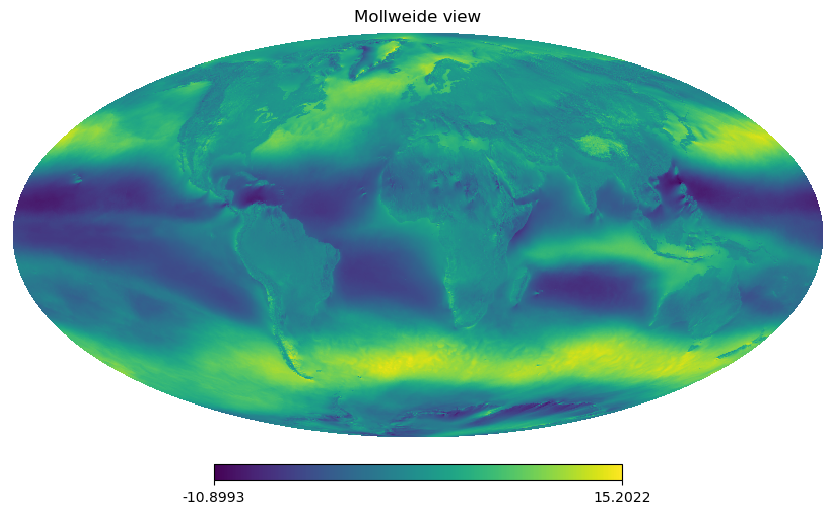

In [11]:
hp.mollview(data_example, flip="geo", nest=True)

### More examples of working with healpix grid: https://github.com/nextGEMS/nextGEMS_prefinal/blob/main/FESOM/Yet_another_HEALPix_example_with_ocean_IFS-FESOM_data.ipynb